In [23]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import mat_neuron.core as matmodel

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

In [24]:
# model parameters: (α1, α2, β, ω, R, τm, τ1, τ2, τV, tref)
matparams = np.asarray([100, 2, -0.3, 7, 10, 10, 10, 200, 5, 2], dtype='d')
# these parameters should be slightly better but produce same output
# matparams = np.asarray([9.27063294,   1.77843253,  -0.29152392,   6.26916095,  13.37407994,
#                        10, 10, 200, 5, 2], dtype='d')
matstate = np.zeros(6, dtype='d')
model_dt = 0.5

# data parameters
duration = 20000
n_samples = int(duration / model_dt)
n_assim = 3
n_test = 0

# assimilation parameters
nthreads = 6
nwalkers = 2000
nsteps = 1000
matparams_i = [0,1,3]
matparams_n = len(matparams_i)
matparams_f = matparams[matparams_i]

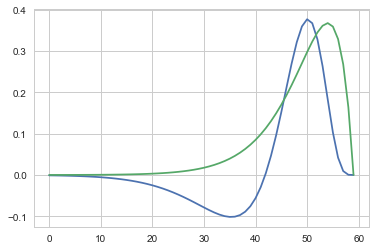

In [25]:
# convolution - simple alpha kernel
from scipy.signal import resample
stim_dt = 10.0
upsample = int(stim_dt / model_dt)

# alpha filter
tau_h = 50
tt = np.arange(0, 600, stim_dt)
ka = np.flipud(tt / tau_h * np.exp(-tt / tau_h))

# difference of gammas:
from scipy.special import gamma
tau_h1 = 600. / 32
tau_h2 = 600. / 16
kg1 = 1/(gamma(6)*tau_h1)*(tt/tau_h1)**5 * np.exp(-tt/tau_h1)
kg2 = 1/(gamma(6)*tau_h2)*(tt/tau_h2)**5 * np.exp(-tt/tau_h2)
kg = np.flipud(kg1 - kg2 / 1.5)
kg /= np.linalg.norm(kg)

plt.plot(kg)
plt.plot(ka)

# select a filter
k1 = ka
def filter_stimulus(S, k1):
    return np.convolve(S, k1, mode="same")

In [26]:
# generate data to fit
np.random.seed(1)
matmodel.random_seed(1)
data = []
stim = np.random.randn(int(n_samples / (stim_dt / model_dt)))
stim[:100] = 0
I = filter_stimulus(stim, k1)
#I = np.random.randn(n_samples)
for i in range(n_assim + n_test):
    states, spikes = matmodel.predict(matstate, matparams, I, model_dt, upsample=upsample, stochastic=True)
    z = np.nonzero(spikes)[0]
    d = {"I_stim": I,
         "duration": duration,
         "states": states,
         "spike_t": z, 
         "spike_v": spikes,
         #"lci": matmodel.log_intensity(matstate, matparams, I, z, model_dt)
         }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

182

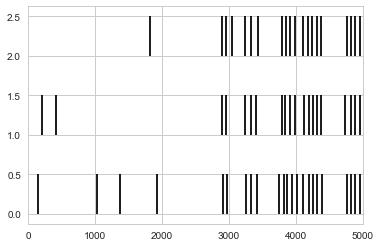

In [27]:
for i, d in enumerate(data):
    plt.vlines(d["spike_t"], i, i + 0.5)
plt.xlim([0, 5000])
len(data[0]["spike_t"])

In [28]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos
import emcee

mat_prior = priors.joint_independent(
                [ priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                  #priors.uniform(-5,   5),
                  priors.uniform( 0,  20),
                  #priors.uniform( 5,  20),
                ])
startparams = np.asarray([[-50, 200],
                          [-5, 10],
                          #[-5, 5],
                          [0, 20],
                          #[5, 20],
                         ], dtype='d')

# lasso prior on RF parameters
rf_lambda = 1.0
def rf_prior(theta):
    return -np.sum(np.abs(theta)) * rf_lambda

# this is the local copy of the parameters that we'll update in each step
mparams = matparams.copy()
rfparams = k1.copy()

def lnpost_dyn(theta):
    """Posterior probability for dynamical parameters"""
    from mat_neuron._model import lci_poisson
    mparams[matparams_i] = theta[:matparams_n]
    rfparams[:] = theta[matparams_n:]    
    ll = mat_prior(theta[:matparams_n]) + rf_prior(rfparams)
    if not np.isfinite(ll):
        return -np.inf
    lp = 0
    I = filter_stimulus(stim, rfparams)
    for d in assim_data:
        lp += lci_poisson(matstate, mparams, I, d["spike_v"], model_dt, upsample)
    return ll + lp        

In [29]:
# theoretically this is as good as it can get
theta_true = np.concatenate([matparams_f, k1])
print("lnpost of p_true: {}".format(lnpost_dyn(theta_true)))
# and this is our initial state
p0 = np.concatenate([startpos.uniform_independent(nwalkers, startparams[:,0], startparams[:,1]),
                     startpos.normal_independent(nwalkers, k1, [0.1] * k1.size)],
                   axis=1)
theta_0 = np.median(p0, 0)
print("lnpost of p0 median: {}".format(lnpost_dyn(theta_0)))
%timeit lnpost_dyn(theta_true)
%time for theta_0 in p0: lnpost_dyn(theta_0)

lnpost of p_true: -1465.6142549969613
lnpost of p0 median: -2886.512840418176
3.53 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CPU times: user 7.12 s, sys: 22.2 ms, total: 7.14 s
Wall time: 7.17 s


In [30]:
sampler = emcee.EnsembleSampler(nwalkers, matparams_f.size, lnpost_dyn, threads=nthreads)
tracker = utils.convergence_tracker(nsteps, 25)

for pos, prob, _ in tracker(sampler.sample(p0, iterations=nsteps, storechain=False)): 
    continue

  step      lnprob        time         ETA
------------------------------------------
    25     -3641.8     0:01:20     0:54:44
    50     -2500.9     0:02:47     0:54:17
    75     -2158.1     0:04:11     0:52:30
   100     -1965.9     0:05:34     0:50:47
   125     -1828.8     0:06:58     0:49:19
   150     -1724.5     0:08:21     0:47:45
   175       -1646     0:09:44     0:46:14
   200     -1592.4     0:11:06     0:44:44
   225     -1555.4     0:12:29     0:43:14
   250     -1530.8     0:13:52     0:41:49
   275     -1514.9     0:15:14     0:40:21
   300     -1503.3     0:16:37     0:38:57
   325     -1494.3     0:18:02     0:37:38
   350       -1487     0:19:28     0:36:20
   375     -1480.9     0:20:51     0:34:55
   400     -1476.1     0:22:14     0:33:30
   425     -1472.1     0:23:37     0:32:05
   450     -1468.9     0:24:58     0:30:38
   475     -1466.1     0:26:19     0:29:12
   500     -1463.6     0:27:41     0:27:47
   525     -1461.2     0:29:02     0:26:22
   550     

lnpost of p median: -1448.065508700778
average acceptance fraction: 0.541903
[ 100.    2.    7.]
[ 101.89188512    1.94839941    7.18746789]


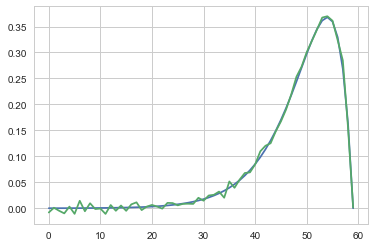

In [31]:
print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
theta = np.median(pos, 0)
mparams[matparams_i] = theta[:matparams_n]
rfparams[:] = theta[matparams_n:]
plt.plot(k1)
plt.plot(rfparams)
print(matparams_f)
print(theta[:matparams_n])

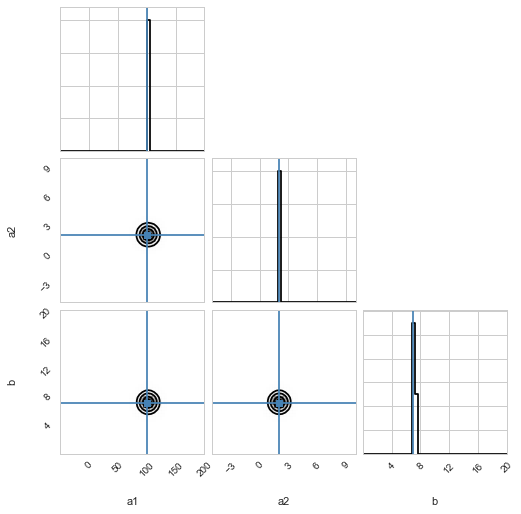

In [32]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:matparams_n]
matlabs = ['a1','a2','b','w', 'R']
c = corner(mpos,
           range=[sp for sp in startparams],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparams_f)

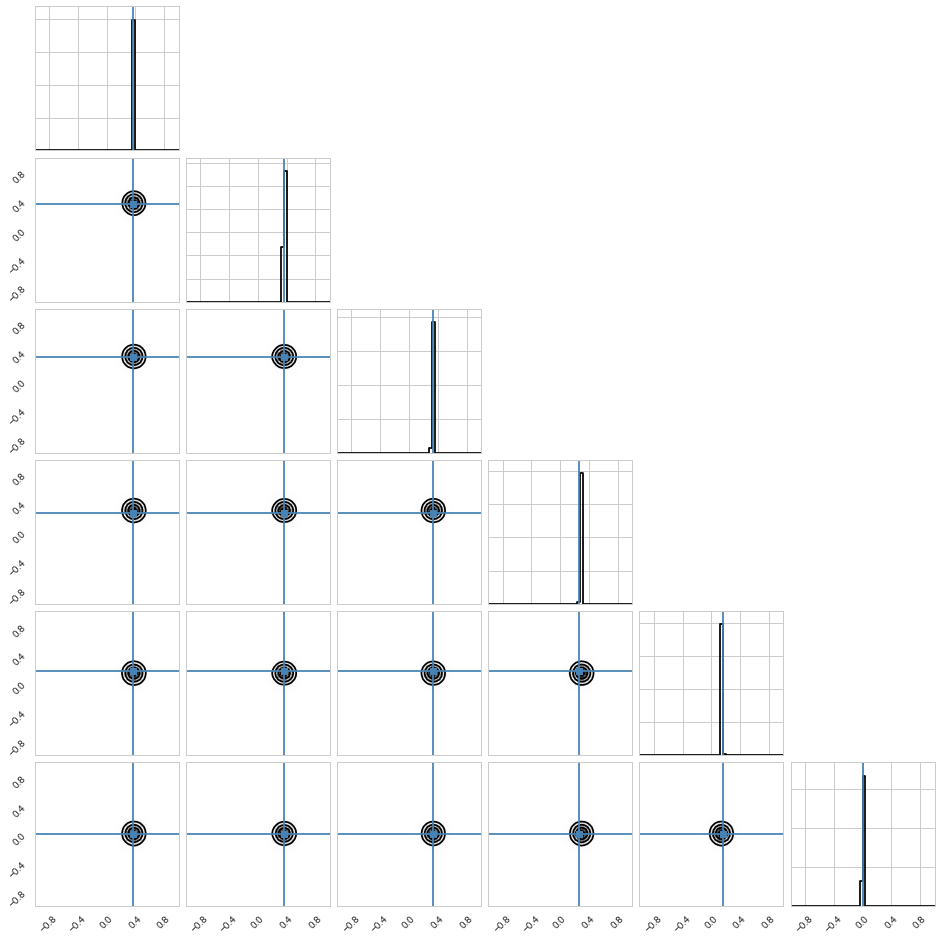

In [33]:
rpos = pos[:,matparams_n:]
c = corner(rpos[:,-6:],
           range=[[-1, 1] for i in range(6)],
           bins=50, smooth=2,smooth1d=0,
           truths=k1[-6:])

In [ ]:
# see how well predictions line up
d = assim_data[0]

Y, S = matmodel.predict(matstate, mparams, I, model_dt, upsample=upsample, stochastic=True)
plt.plot(d["states"][:4000,1])
plt.plot(Y[:4000,1])

In [ ]:
plt.plot(d["states"][:4000,0])
plt.plot(d["states"][:4000,0] - d["states"][:4000,4])
plt.plot(Y[:4000,0])

In [ ]:
for i, d in enumerate(data):
    plt.vlines(d["spike_t"], i, i + 0.5, 'r')

for i in range(len(data), len(data) + 10):
    Y, S = matmodel.predict(matstate, mparams, I, model_dt, upsample=upsample, stochastic=True)
    spk_t = S.nonzero()[0]
    plt.vlines(spk_t, i, i + 0.5)

plt.xlim(0, 10000)

In [ ]:
(d["lci"] - lci_guess).mean()